# House Prices - Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

# 0. recuperare il dataset (da internet o da locale)
# 1. feature selection (principal component analysis)
# 2. Suddivisione training e testing
# 3. Model selection con K-fold cross validation
# 4. Training (Tuning iperparametri) con k-fold cross validation
# 5. Valutare il modello con il testing set
# 6. Scegliere il metodo di score (R^2)
# 7. Fare dei grafici, vedendo anche da come li ha fatti il professore e spiegarli.
# Bagging, Boosting (Gradient Boosting) e altro

In [1]:
from feature_selection import FeatureSelection, FS
from grafici import Grafici
from models import Model
from dataset import HouseDataset
import pandas as pd
import numpy as np

dataset = HouseDataset(preprocessing=True)
model = Model(dataset)
feature_sel = FeatureSelection(dataset.get_features(), dataset.get_target())
plot = Grafici(model)

ValueError: could not broadcast input array from shape (1460,77) into shape (1460,)

# Preprocessing valori nulli

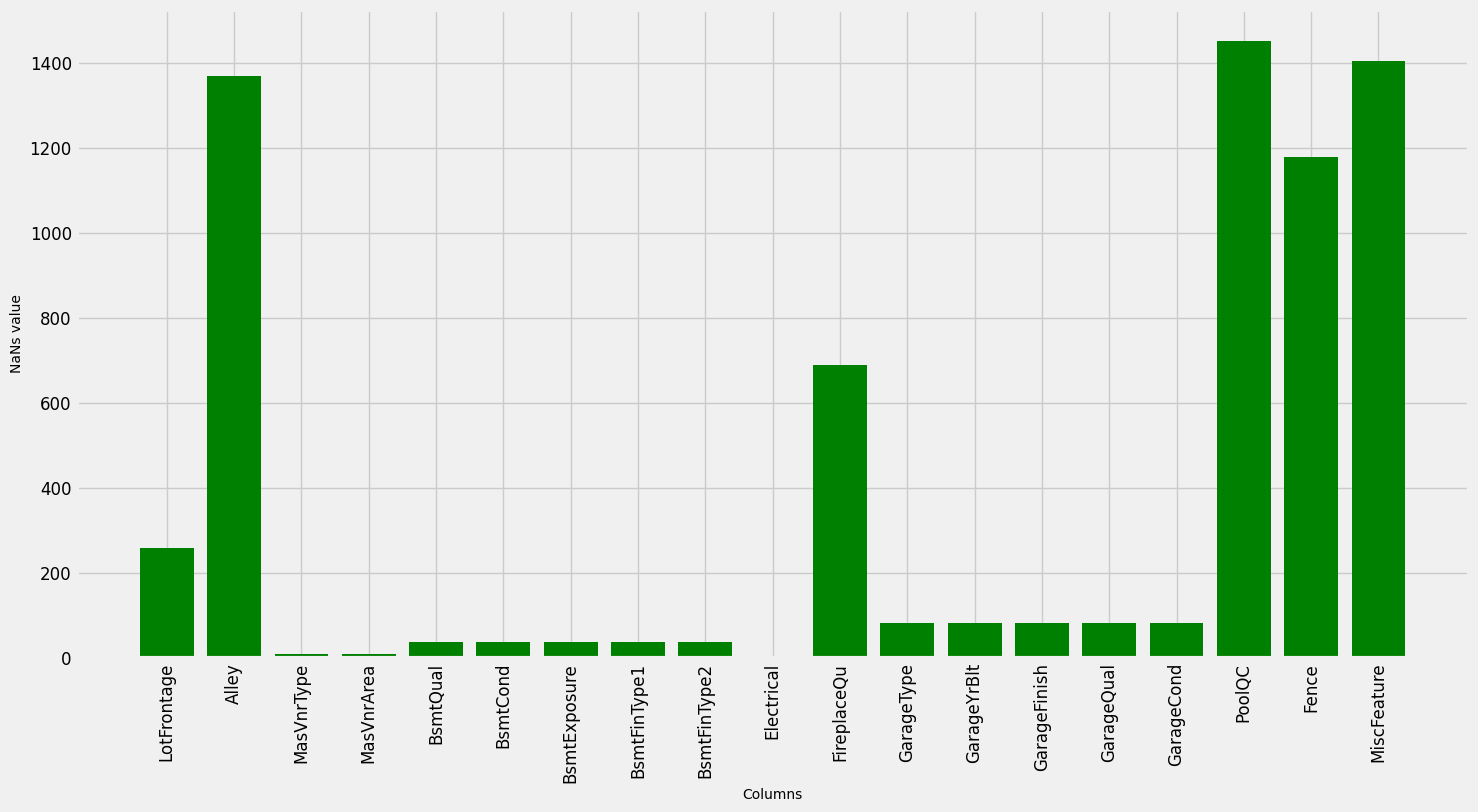

In [2]:
from grafici import check_nan_value

dataset_no_processing = HouseDataset(preprocessing=False)
check_nan_value(dataset_no_processing.train)

# Regressione lineare con Select-K-best

In [13]:
print("FS.SELECT_K_BEST")
scores_kbest = model.linear_regression_fs(FS.SELECT_K_BEST)

for s in scores_kbest:
    print("MSE: ", s)

FS.SELECT_K_BEST
MSE:  (10, 1328167577.6289647)
MSE:  (20, 1182682370.3731995)
MSE:  (30, 1104741330.853421)
MSE:  (40, 1012303423.1295481)
MSE:  (50, 948137383.8622311)
MSE:  (60, 929795932.8407598)
MSE:  (70, 903007997.987648)
MSE:  (80, 857607106.7584373)
MSE:  (90, 797190122.4316925)
MSE:  (100, 787704351.698497)
MSE:  (110, 772329106.9752275)
MSE:  (120, 735056623.9047996)
MSE:  (130, 711174622.637917)
MSE:  (140, 705483536.494748)
MSE:  (150, 664240517.9218501)
MSE:  (160, 660469830.7448843)
MSE:  (170, 653610334.7970495)
MSE:  (180, 616079715.3828783)
MSE:  (190, 606956057.5112576)
MSE:  (200, 600718838.3074635)
MSE:  (210, 595887667.1558391)
MSE:  (220, 588147771.0365868)
MSE:  (230, 583057051.2045997)
MSE:  (240, 577519177.475977)
MSE:  (250, 574329169.669406)
MSE:  (260, 553631853.2715001)
MSE:  (270, 437722083.90319216)


Plot in variazione dei valori mse:

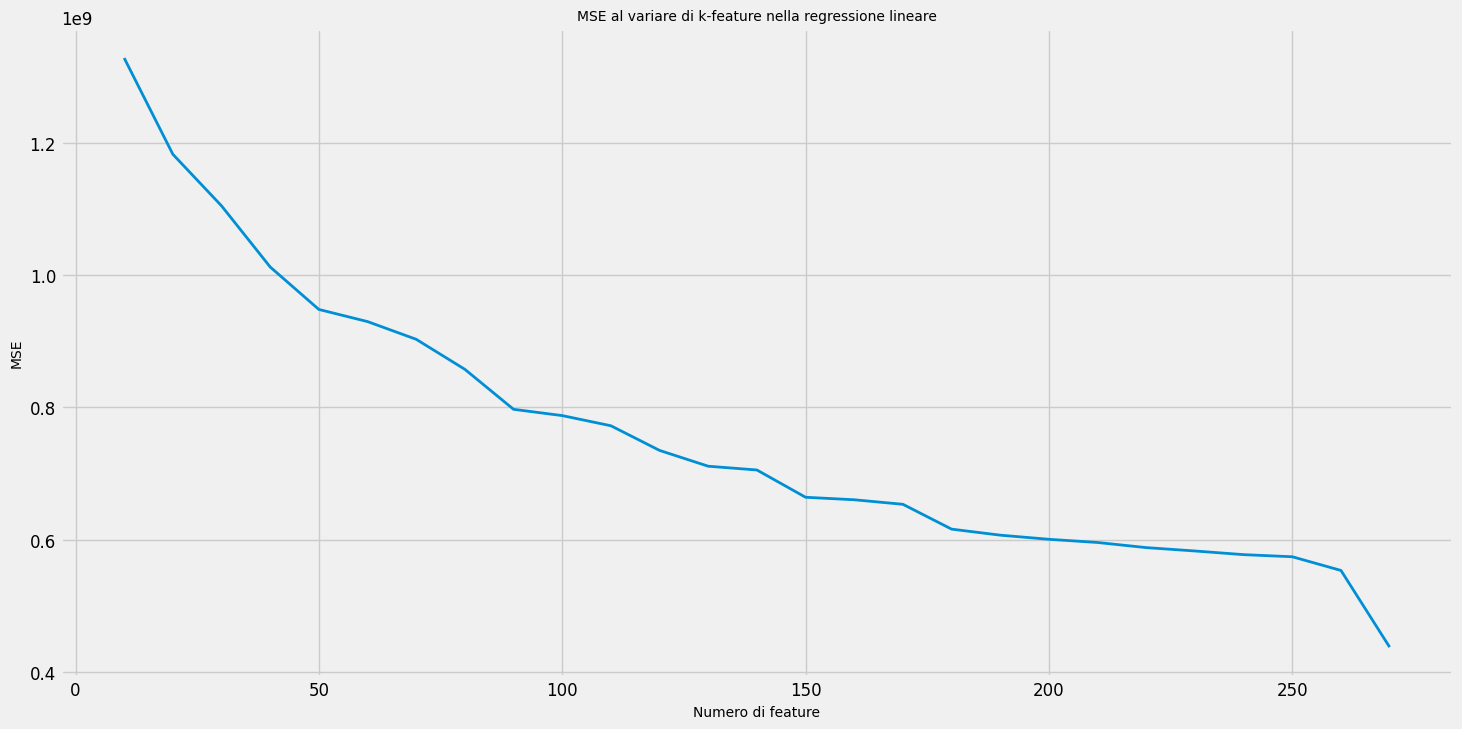

In [14]:
scores_kbest = np.array(scores_kbest)
plot.mse_linear_regression_plot(scores_kbest)

In [15]:
min_index = np.argmin(scores_kbest[:, 1]) # minor mse
print('Minor mse: {0:5}. MSE={1:.3f}'.format(int(scores_kbest[min_index, 0]), scores_kbest[min_index, 1]))

Minor mse:   270. MSE=437722083.903


In [16]:
scores_kbest, y_pred_kbest = model.linear_regression(FS.SELECT_K_BEST, (int(scores_kbest[min_index, 0])))

print('MSE: {0:.3f}'.format(-scores_kbest.mean()))

MSE: 1196709168.941


Plot sulla predizione dei valori del training:

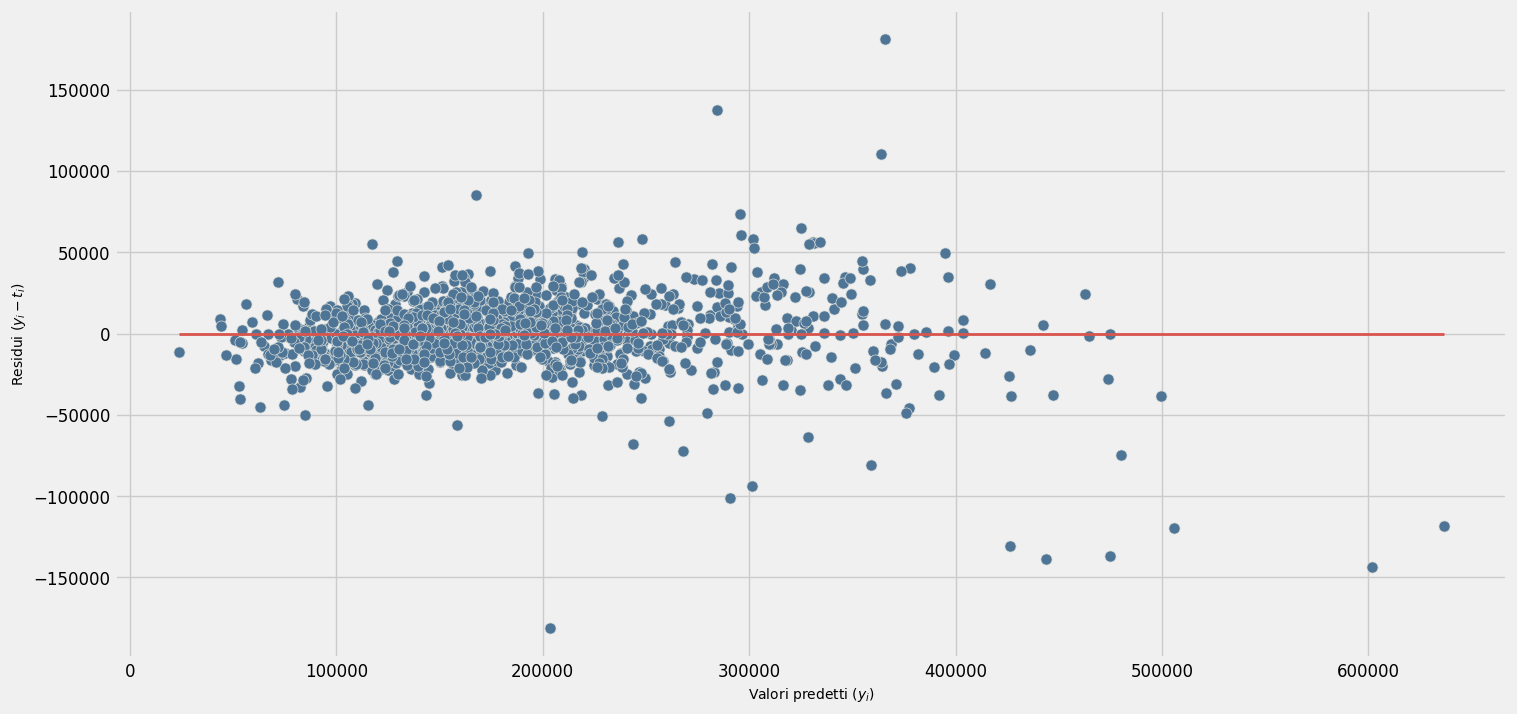

In [17]:
plot.linear_regression_plot(model.y_train, y_pred_kbest)

# Regressione lineare con Mutual Information

In [21]:
print("FS.MUTUAL_INFORMATION")
scores_mi = model.linear_regression_fs(FS.MUTUAL_INFORMATION)

for s in scores_mi:
    print("MSE: ", s)

FS.MUTUAL_INFORMATION
MSE:  (10, 1410306632.3304217)
MSE:  (20, 1297576818.8571904)
MSE:  (30, 1048109877.00496)
MSE:  (40, 1016068223.3624343)
MSE:  (50, 975178920.5653962)
MSE:  (60, 915173501.7289882)
MSE:  (70, 881303503.2197043)
MSE:  (80, 852005028.7645509)
MSE:  (90, 838205444.7041854)
MSE:  (100, 820968200.7577204)
MSE:  (110, 779171581.7781148)
MSE:  (120, 787876624.856913)
MSE:  (130, 740956275.272535)
MSE:  (140, 739566352.9502451)
MSE:  (150, 691056613.0826874)
MSE:  (160, 663612976.4911374)
MSE:  (170, 714188717.230848)
MSE:  (180, 632096254.770364)
MSE:  (190, 644487688.6255684)
MSE:  (200, 478844056.1027381)
MSE:  (210, 603321763.5190735)
MSE:  (220, 567153882.220064)
MSE:  (230, 462198623.9930449)
MSE:  (240, 453797471.0490984)
MSE:  (250, 453902315.48471344)
MSE:  (260, 441523250.25684905)
MSE:  (270, 439038969.93790984)


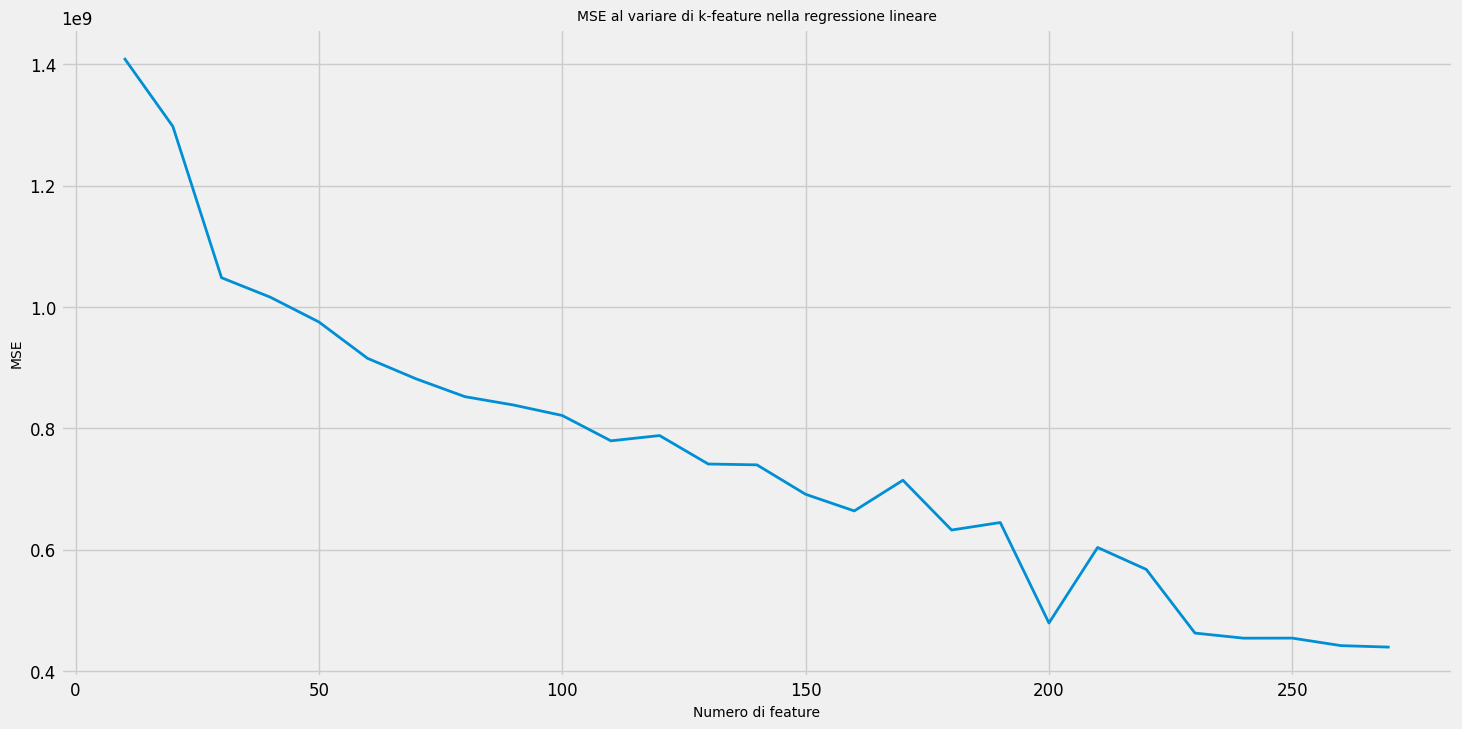

In [22]:
scores_mi = np.array(scores_mi)
plot.mse_linear_regression_plot(scores_mi)

Scegliamo il miglior valore di mse:

In [23]:
min_index = np.argmin(scores_mi[:, 1])
print('Minor mse: {0:5}. MSE={1:.3f}'.format(int(scores_mi[min_index, 0]), scores_mi[min_index, 1]))

Minor mse:   270. MSE=439038969.938


Applichiamo il modello di regressione lineare:

In [24]:
scores_mi, y_pred_mi = model.linear_regression(FS.SELECT_K_BEST, (int(scores_mi[min_index, 0])))

print('MSE: {0:.3f}'.format(-scores_mi.mean()))

MSE: 1196709168.941


Plot sulla predizione dei valori del training:

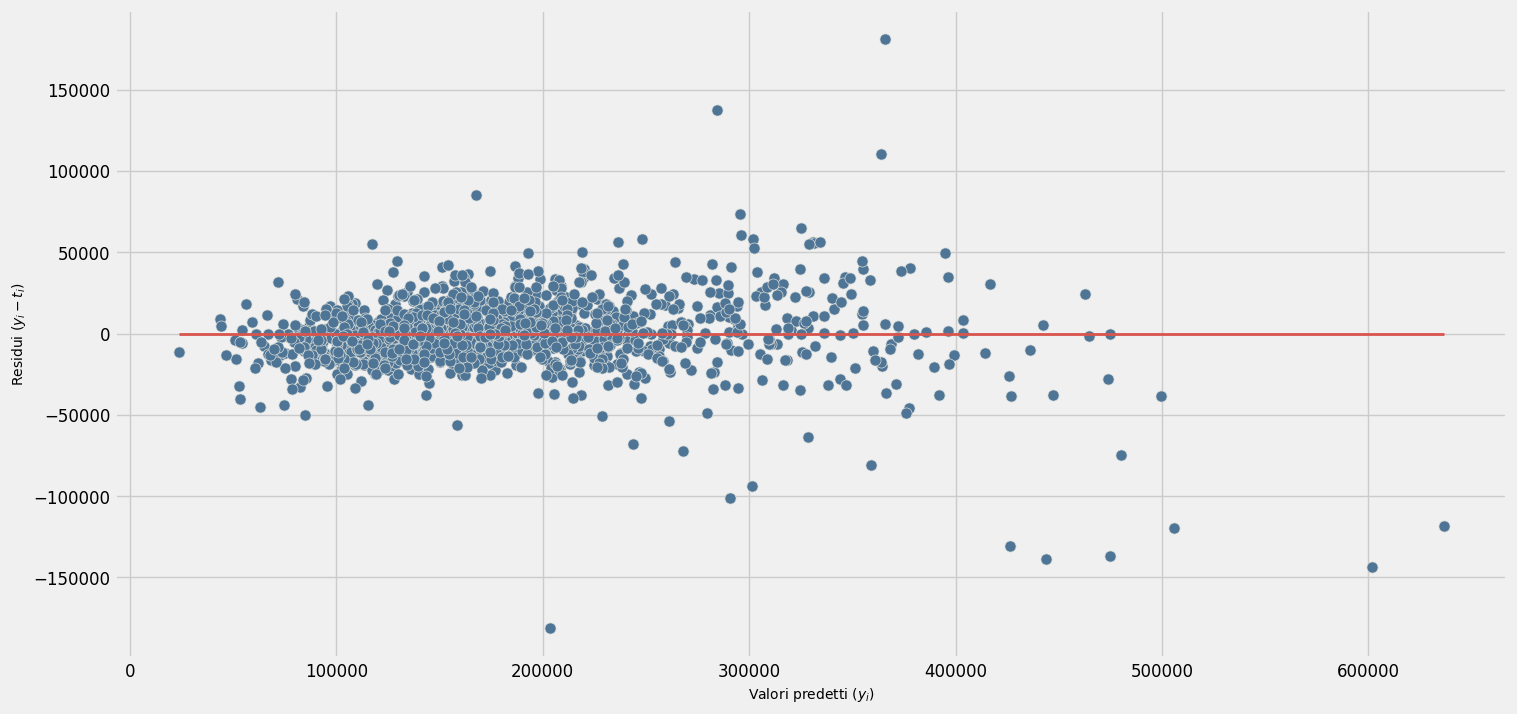

In [25]:
plot.linear_regression_plot(model.y_train, y_pred_mi)

# Lasso

Determiniamo il miglior valore di alpha per il modello di regressione Lasso.

In [ ]:
alpha, coef_regressione = model.lasso_cv_regression()
print("Coefficienti di regressione: " , coef_regressione)
print("Miglior valore di alpha:", alpha)

Applichiamo il modello di regressione lasso con il miglior alpha ottenuto:

In [ ]:
scores, y_pred = model.lasso_regression(alpha, 10)
print('MSE: {0:.3f}'.format(-scores.mean()))

In [ ]:
plot.lasso_regression_plot(model.y_train, y_pred)

# Feature Selection - Mutual Information
La Mutual Information (informazione mutua) è una metrica che viene utilizzata nell'apprendimento automatico (ML) per misurare quanto due variabili casuali sono dipendenti l'una dall'altra.

In termini matematici, la mutual information tra due variabili casuali X e Y è definita come la quantità di informazione che X fornisce su Y (o viceversa). In altre parole, la mutual information misura quanto l'incertezza di una variabile casuale diminuisce conoscendo l'altra variabile casuale.

In ML, la mutual information viene spesso utilizzata per selezionare le caratteristiche più rilevanti per una determinata attività di apprendimento. Ad esempio, quando si lavora con un insieme di dati, si può utilizzare la mutual information per valutare quanto una caratteristica specifica del dataset è rilevante per la variabile target.

In pratica, si può calcolare la mutual information tra ogni caratteristica del dataset e la variabile target e quindi selezionare le caratteristiche con la mutual information più alta.

La mutual information può anche essere utilizzata per la riduzione della dimensionalità dei dati, in modo da semplificare l'analisi e il calcolo. In questo caso, si possono selezionare solo le caratteristiche con la mutual information più alta, in modo da ridurre il numero di variabili senza perdere informazioni importanti per il modello di apprendimento automatico.

In [ ]:
mi = feature_sel.mutual_information()
dmi = pd.DataFrame(mi, index=dataset.get_features().columns, columns=['mi']).sort_values(by='mi', ascending=False)
dmi.head(10)
feat = list(dmi.index[:10])
print(feat)
X = dataset.get_features()[feat].values
print(X)

In [ ]:
# Lascio solo per reference
import torch
import torch.nn as nn
import numpy as np
from code.dataset import HouseDataset
from sklearn.feature_selection import SelectKBest, f_regression

# Load Boston Housing dataset
boston = HouseDataset()
X, y = boston.get_features(), boston.get_target()

# Select top 5 features using f_regression
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Convert data to PyTorch tensors
X_new = torch.from_numpy(X_new).float()
y = torch.from_numpy(y).float()

# Define the model
model = nn.Linear(X_new.shape[1], 1)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_new)
    loss = criterion(outputs, y.view(-1, 1))

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss for every 100th epoch
    if (epoch + 1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

